# Concrete Strength - Regression - Models
Target = Strength
Metric = RMSE

I take notes from winners. See below.
https://www.kaggle.com/code/ambrosm/pss3e9-winning-model


In [ ]:
# Module Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

import lightgbm, xgboost
from lightgbm import LGBMRegressor
from lofo import LOFOImportance, Dataset, plot_importance

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels

In [3]:
# Global Variables
result_list = []
jns_rand = 29

# Load and Combine the Data

In [4]:
train = pd.read_csv('./datasets/concrete_strength/train.csv', index_col='id')
test = pd.read_csv('./datasets/concrete_strength/test.csv', index_col='id')
original = pd.read_csv('./datasets/concrete_strength/ConcreteStrengthData.csv')
original.rename(columns={'CementComponent ': 'CementComponent'}, inplace=True)

target = 'Strength'
original_features = list(test.columns)

train.head(3)

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
id,,,,,,,,,
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96


In [5]:
training_df = pd.concat([train, original], ignore_index=False)
training_df.shape

(6437, 9)

# EDA

In [6]:
sns.set_theme(style="darkgrid")
sns.set_palette("colorblind")

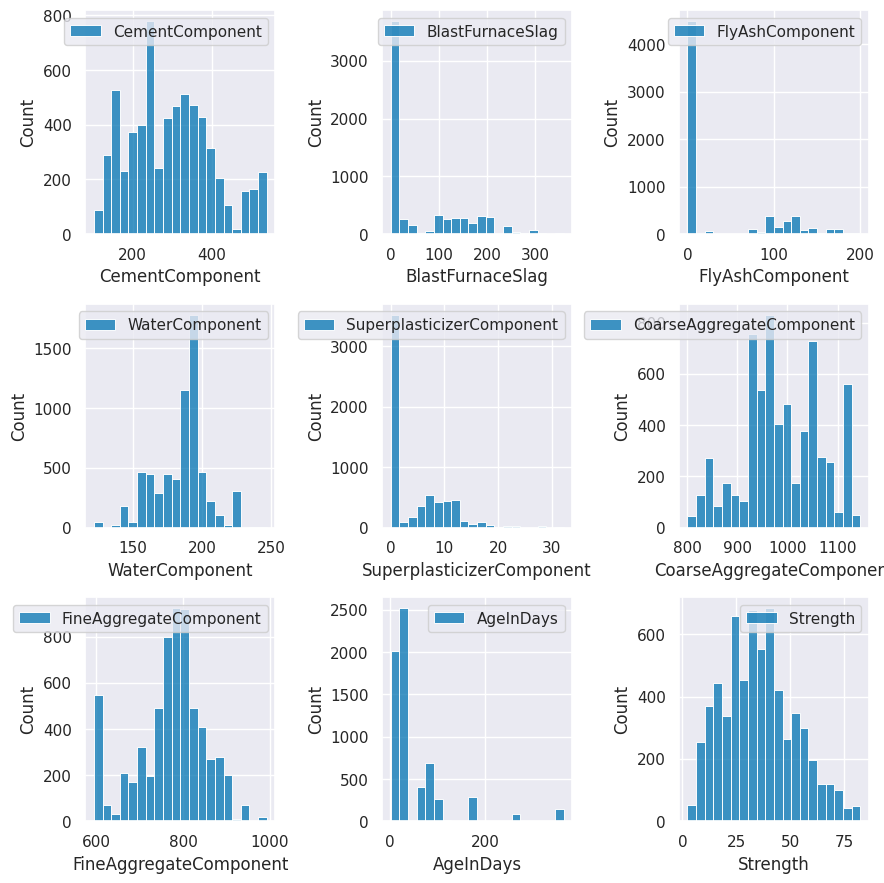

In [10]:
n_rows = 3
n_cols = 3

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(9, 9))

for i, name in enumerate(training_df.columns):
    row = i // n_rows
    col = i % n_cols

    ax = axes[row, col]
    sns.histplot(training_df[name], bins=20, ax=ax, label=name)
    ax.legend()

plt.tight_layout()
plt.show()

Age in Days appears to be categorical. All other features appear to be continuous.

# Correlation Matrix

<Axes: >

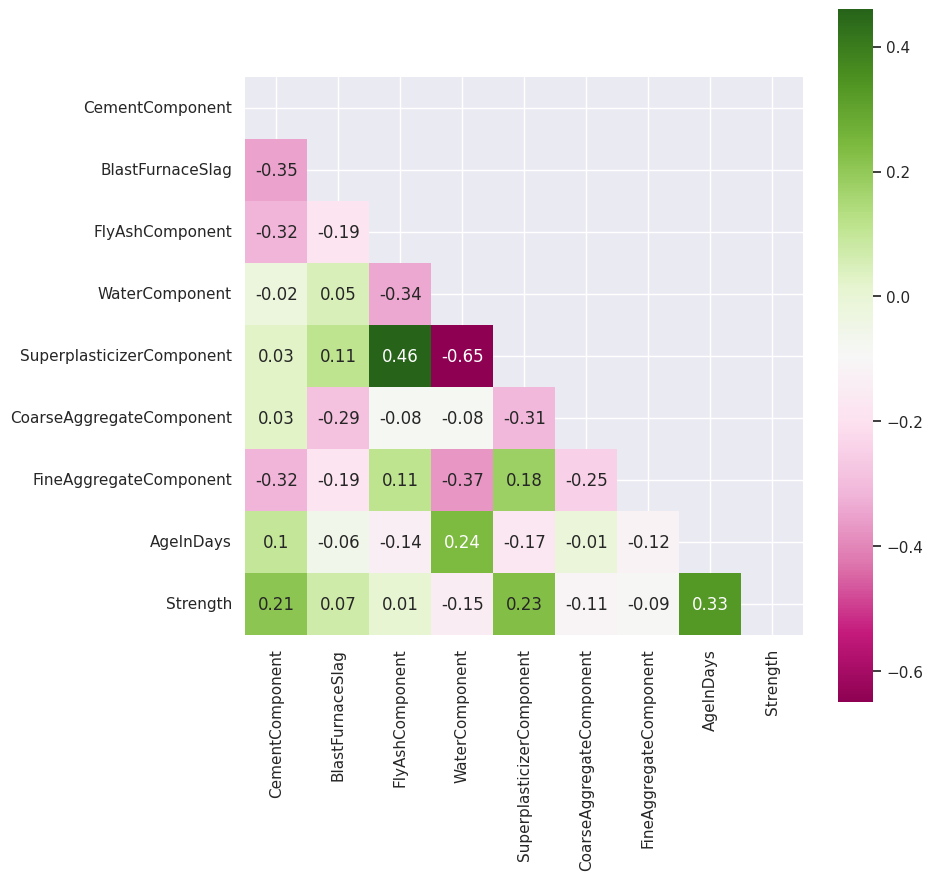

In [11]:
# Compute the correlation matrix
corr = training_df.corr()

# Mask upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up mpl figure
fig, axes = plt.subplots(figsize=(9,9))

# Make the corrplot
sns.heatmap(corr.round(2), mask=mask, cmap="PiYG", annot=True, square=True)

Strength has high correlations to cement, superplasticizer, and age.
Before Feature Engineering, view the counts of each AgeInDays.

In [12]:
training_df['AgeInDays'].value_counts()

28     2522
7       922
3       773
90      594
56      404
14      311
180     290
100     264
365     105
91       95
270      88
360      43
120      18
1         7
49        1
Name: AgeInDays, dtype: int64

In [13]:
test['AgeInDays'].value_counts()

28     1377
7       549
3       414
90      382
56      213
180     190
14      186
100     122
91       51
270      41
365      40
120      21
360      15
1         3
11        1
Name: AgeInDays, dtype: int64

Concrete measurements are typically taken at 3, 7, 14, 28, 56, 90, 120, 180, 270, and 365.
Concrete strength at 28 days is the gold standard.
Sometimes one is off a day or 3.

# Feature Engineering

In [14]:
def replace_age(x):
    if x == 1: return 3
    if x == 11: return 14
    if x == 49: return 56
    if x == 91: return 90
    if x == 360: return 365
    return x

def concrete_fe(df):
    df['w:cm'] = df['WaterComponent'] / (df['CementComponent'] +
                                         df['BlastFurnaceSlag'] +
                                         df['FlyAshComponent'])

    df['superP:cm'] = df['SuperplasticizerComponent'] / (df['CementComponent'] +
                                                         df['BlastFurnaceSlag'] +
                                                         df['FlyAshComponent'])

    df['paste:agg'] = (df['WaterComponent'] +
                       df['CementComponent'] +
                       df['BlastFurnaceSlag'] +
                       df['FlyAshComponent']) / (df['CoarseAggregateComponent'] +
                                                 df['FineAggregateComponent'])

    df['coarse:fine'] = df['CoarseAggregateComponent'] / df['FineAggregateComponent']

    df['age:water'] = df['AgeInDays'] / df['WaterComponent']

    df['age:cement'] = df['AgeInDays'] / df['CementComponent']

    return df

In [15]:
# Apply Feature Engineering to training at test datasets
training_df['AgeInDays'] = training_df['AgeInDays'].apply(replace_age)
test['AgeInDays'] = test['AgeInDays'].apply(replace_age)

training_df = concrete_fe(training_df)
test = concrete_fe(test)

# Feature Importance

In [16]:
features = test.columns

In [17]:
# Create some LightGBM trees to determine which features are important.
# https://github.com/aerdem4/lofo-importance#readme

kfold_importance = KFold(n_splits=5, shuffle=True, random_state=jns_rand)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

dataset = Dataset(
    df=training_df.sample(frac=1, random_state=jns_rand),
    target=target,
    features=features
)

lgbm = LGBMRegressor(random_state=jns_rand)

lofo_importance = LOFOImportance(
    dataset=dataset,
    cv=kfold_importance,
    scoring=scorer,
    model=lgbm
)

  0%|          | 0/14 [00:00<?, ?it/s]

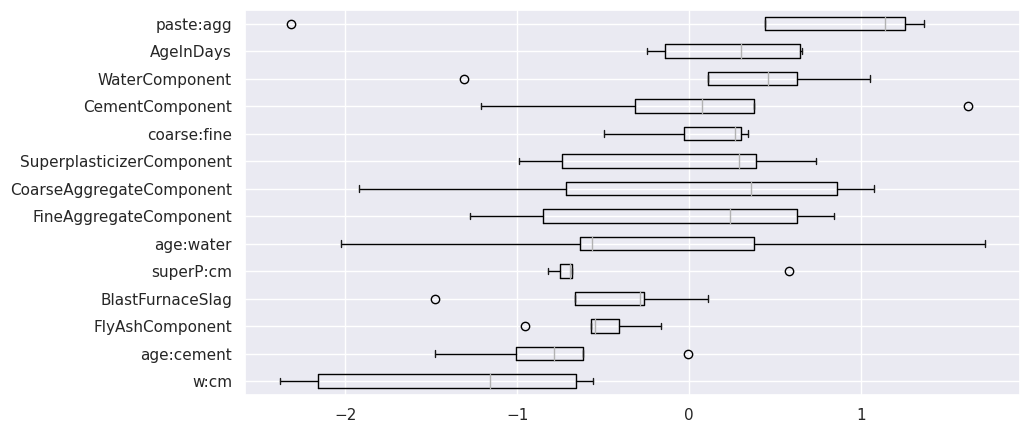

In [18]:
plot_importance(
    lofo_importance.get_importance(),
    figsize=(10,5),
    kind='box'
)

Things that I know to be important for concrete strength, such as water:cm ratio, averages to less importance. Slag and Fly ash having less importance makes more sense, maybe. I think I am going to keep all these features.

# Model - KFold Function

In [19]:
# KFold CV Model
def kfold_scorer(model, df, features, target, folds=5, label=None):
    #Cross-Validate the given model, dataframe, and features within it
    score_list = []
    oof = np.zeros_like(df[target], dtype=float)
    kf = KFold(n_splits=folds, shuffle=True)

    for fold, (idx_tr, idx_va) in enumerate(kf.split(df)):
        X_tr = df.iloc[idx_tr][features]
        y_tr = df.iloc[idx_tr][target]
        X_va = df.iloc[idx_va][features]
        y_va = df.iloc[idx_va][target]

        model.fit(X_tr, y_tr)
        y_va_pred = model.predict(X_va)

        rmse_tr = mean_squared_error(y_tr, model.predict(X_tr), squared=False)
        rmse_va = mean_squared_error(y_va, y_va_pred, squared=False)

        print(f'Fold {fold}: rmse_tr = {rmse_tr:0.4f}  rmse_va = {rmse_va:0.4f}')

        oof[idx_va] = y_va_pred
        score_list.append(rmse_va)

    rmse = sum(score_list) / len(score_list)
    print(f"Average RMSE: {rmse:0.4f} {label if label is not None else ''}")

    if label is not None:
        global result_list
        result_list.append((label, model, features, rmse, oof))

# Model - Linear Ridge
Use ridge regression, to get a baseline rmse for the other models.

In [20]:
%%time

kfold_scorer(
    model=make_pipeline(
        ColumnTransformer([('ohe', OneHotEncoder(drop='first'),
                            ['AgeInDays'])]),
        Ridge(alpha=1, random_state=jns_rand)),

    df=training_df,
    features=features,
    target=target,
    label="Ridge OHE"
)

Fold 0: rmse_tr = 12.9430  rmse_va = 13.2047
Fold 1: rmse_tr = 13.0115  rmse_va = 12.9383
Fold 2: rmse_tr = 13.1248  rmse_va = 12.4790
Fold 3: rmse_tr = 12.9209  rmse_va = 13.2998
Fold 4: rmse_tr = 12.9658  rmse_va = 13.1187
Average RMSE: 13.0081 Ridge OHE
CPU times: user 178 ms, sys: 1.9 ms, total: 180 ms
Wall time: 204 ms


# Model - Random Forests

In [21]:
%%time

# I tried OHE on RF, but it made average RMSE higher.

kfold_scorer(
    model=RandomForestRegressor(
            n_estimators=1000,
            min_samples_leaf=15,

            n_jobs=-1,
            random_state=jns_rand
    ),
    df=training_df,
    features=features,
    target=target,
    label="RF 1000n"
)

Fold 0: rmse_tr = 10.6196  rmse_va = 11.4913
Fold 1: rmse_tr = 10.5747  rmse_va = 11.6629
Fold 2: rmse_tr = 10.4858  rmse_va = 11.8788
Fold 3: rmse_tr = 10.4814  rmse_va = 11.9629
Fold 4: rmse_tr = 10.4499  rmse_va = 12.1733
Average RMSE: 11.8338 RF 1000n
CPU times: user 2min 26s, sys: 1.52 s, total: 2min 27s
Wall time: 1min 33s


# Model - Gaussian Process Regressor
Going to be real. I am keeping this in here because of AmbroseM. I still need to learn more about this.

# Model - Gradient Boosting

In [22]:
%%time

# I messed with these parameters quite a bit.

gbr_params = {
    'n_estimators': 600,
    'max_depth': 4,
    'learning_rate': 0.01,
    'min_samples_leaf': 15,
    'max_features': 3,
}

kfold_scorer(
    model=GradientBoostingRegressor(**gbr_params, random_state=jns_rand),
    df=training_df,
    features=features,
    target=target,
    label="sk Gradient Boosting"
)

Fold 0: rmse_tr = 11.0903  rmse_va = 11.6772
Fold 1: rmse_tr = 11.0658  rmse_va = 11.7082
Fold 2: rmse_tr = 11.0388  rmse_va = 11.8151
Fold 3: rmse_tr = 10.9650  rmse_va = 12.0386
Fold 4: rmse_tr = 11.1772  rmse_va = 11.2164
Average RMSE: 11.6911 sk Gradient Boosting
CPU times: user 14.8 s, sys: 37.7 ms, total: 14.9 s
Wall time: 16.6 s


# Model - XGBoost

In [26]:
%%time

xgb_params = {
    'n_estimators': 700,
    'learning_rate': 0.01,
    'max_depth': 4,
    'min_child_weight': 15,

    'subsample': 1.0,
    'colsample_bytree': 1.0,

    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',

    'n_jobs': -1,

    'verbosity': 1,
    'random_state': 29
}

kfold_scorer(
    model=xgboost.XGBRegressor(**xgb_params),
    df=training_df,
    features=features,
    target=target,
    label="XGboost"
)

Fold 0: rmse_tr = 10.9939  rmse_va = 11.4178
Fold 1: rmse_tr = 10.9115  rmse_va = 11.6677
Fold 2: rmse_tr = 10.9163  rmse_va = 11.6537
Fold 3: rmse_tr = 10.8629  rmse_va = 11.9916
Fold 4: rmse_tr = 10.9019  rmse_va = 11.7708
Average RMSE: 11.7003 XGboost
CPU times: user 35.5 s, sys: 236 ms, total: 35.7 s
Wall time: 21.3 s


# View Results and Ensemble

In [27]:
result_list

[('Ridge OHE',
  Pipeline(steps=[('columntransformer',
                   ColumnTransformer(transformers=[('ohe',
                                                    OneHotEncoder(drop='first'),
                                                    ['AgeInDays'])])),
                  ('ridge', Ridge(alpha=1, random_state=29))]),
  Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
         'WaterComponent', 'SuperplasticizerComponent',
         'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays',
         'w:cm', 'superP:cm', 'paste:agg', 'coarse:fine', 'age:water',
         'age:cement'],
        dtype='object'),
  13.008108141617129,
  array([18.32316654, 37.71456258, 37.87413058, ..., 37.60907567,
         37.87413058, 37.52111729])),
 ('RF 1000n',
  RandomForestRegressor(min_samples_leaf=15, n_estimators=1000, n_jobs=-1,
                        random_state=29),
  Index(['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent',
         'WaterComponent', 

In [28]:
# DataFrame of all results, sorted by score
result_df = pd.DataFrame(
    result_list,
    columns=['label', 'model', 'features', 'rmse', 'oof']
)
result_df.drop_duplicates(subset='label', keep='last', inplace=True)
result_df = result_df[~result_df.label.str.contains('mean')]
result_df.sort_values('rmse', inplace=True)
result_df.reset_index(drop=True, inplace=True)

result_df

,label,model,features,rmse,oof
0,sk Gradient Boosting,([DecisionTreeRegressor(criterion='friedman_ms...,"Index(['CementComponent', 'BlastFurnaceSlag', ...",11.691116,"[25.75000072119855, 34.15591159071779, 38.1334..."
1,XGboost,"XGBRegressor(base_score=None, booster=None, ca...","Index(['CementComponent', 'BlastFurnaceSlag', ...",11.700331,"[22.064619064331055, 33.05524444580078, 39.927..."
2,RF 1000n,"(DecisionTreeRegressor(max_features=1.0, min_s...","Index(['CementComponent', 'BlastFurnaceSlag', ...",11.833847,"[24.929839135341005, 32.53586587228454, 41.794..."
3,Ridge OHE,"(ColumnTransformer(transformers=[('ohe', OneHo...","Index(['CementComponent', 'BlastFurnaceSlag', ...",13.008108,"[18.32316653696493, 37.71456258448515, 37.8741..."


In [29]:
# Make a DataFrame of the out-of-fold results and their model for
# Model weighting
oof_results_df = pd.DataFrame()
for i in range(len(result_df)):
    oof_results_df[result_df.loc[i]['label']] = pd.Series(result_df.loc[i]['oof'])

oof_results_df.head(5)

,sk Gradient Boosting,XGboost,RF 1000n,Ridge OHE
0,25.750001,22.064619,24.929839,18.323167
1,34.155912,33.055244,32.535866,37.714563
2,38.133483,39.927868,41.794732,37.874131
3,44.556207,45.101078,43.287022,44.109474
4,45.176147,45.044022,48.021443,45.288458


Use Ridge Regression to make the Ensemble

In [30]:
optimum_blend = Ridge(positive=True, tol=1e-6, alpha=100)
optimum_blend.fit(oof_results_df, training_df.Strength.values)
optimum_oof = optimum_blend.predict(oof_results_df)

trmse = mean_squared_error(training_df.Strength.values, optimum_oof,
                           squared=False)

print(f'Ridge regression blend rmse: {trmse:0.5f}')

display(pd.Series(optimum_blend.coef_.round(4), oof_results_df.columns,
                  name='weight'))

result_list.append(('Optimum Blend', None, None, trmse, optimum_oof))

Ridge regression blend rmse: 11.67059


sk Gradient Boosting    0.4624
XGboost                 0.4428
RF 1000n                0.0577
Ridge OHE               0.0573
Name: weight, dtype: float64

# Predict and Submit

In [31]:
%%time

test_preds_df = pd.DataFrame(index=test.index)
for i in range(len(result_df)):
    test_model = result_list[i][1]
    test_preds_df[result_list[i][0]] = test_model.predict(test[features])

test_preds_df['blend'] = optimum_blend.predict(test_preds_df[[
    'sk Gradient Boosting',
    'XGboost',
    'RF 1000n',
    'Ridge OHE'
]])

test_preds_df

CPU times: user 792 ms, sys: 81.1 ms, total: 873 ms
Wall time: 591 ms


,Ridge OHE,RF 1000n,sk Gradient Boosting,XGboost,blend
id,,,,,
5407,52.271281,49.446761,48.237766,48.159592,48.773384
5408,23.919317,21.064899,18.544682,18.734116,18.753425
5409,37.714563,31.029772,33.584557,33.873028,33.775912
5410,47.793062,48.392235,46.721896,48.077957,47.718751
5411,37.714563,28.160334,26.903721,28.433743,28.113150
...,...,...,...,...,...
9007,37.714563,33.042785,33.366855,31.126030,32.575120
9008,37.714563,32.431501,34.173007,34.399719,34.362032
9009,37.714563,42.043023,38.066504,38.021164,38.320019


In [34]:
submission = pd.read_csv('./datasets/concrete_strength/sample_submission.csv', index_col='id')
submission['Strength'] = test_preds_df['blend']
#submission.to_csv('submission_a.csv', index='id')
submission

,Strength
id,
5407,48.773384
5408,18.753425
5409,33.775912
5410,47.718751
5411,28.113150
...,...
9007,32.575120
9008,34.362032
9009,38.320019
